In [1]:
%run InitAndFuctions.ipynb

Host: c2391c0ea7fc
3.6.8 (default, Nov 16 2020, 16:55:22) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-44)] <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7f1a9c83f5c0>
Welcome to JupyROOT 6.22/06


In [2]:
#
# carica i dati dal file
#
# bandella
file_out=mybasepath+"out/dbscan_run4184_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz"
file_out=mybasepath+"out/dbscan_run4184_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4183.plk.gz"
# KFC
file_out=mybasepath+"out/dbscan_run4039_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038_vF0.plk.gz"
#file_out=mybasepath+"out/dbscan_run4046_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz"
#file_out=mybasepath+"out/dbscan_run4160_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4183.plk.gz"
file_out=mybasepath+"out/dbscan_run4045_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038_vF0.plk.gz"
df = pd.read_pickle(file_out, compression='gzip')

# range
# charge distribution
# charge asimettriy

df['length'] = np.sqrt((df['x0end'] - df['x0start'])**2 + (df['y0end'] - df['y0start'])**2)
df['x0c'] = (df['x0end'] + df['x0start'])/2.
df['y0c'] = (df['y0end'] + df['y0start'])/2.
df = df[(df['cluster_lable'] > -1) & (df['width'] > 0) & (df['height'] > 0)]

In [3]:
fileInfo = FileNameInfo(file_out)
print(fileInfo)
run_info_logbook(int(fileInfo.dbscan[0].split('run')[-1]), verbose=False)

    dbscan cmin cmax rescale nsigma   ev   ped     version
0  run4045    0  500    2304    1.5  200  4038  vF0.plk.gz


File_Number                                        4045
saved_events                                        200
Exposure_Time_ms                                      1
comments                          55Fe - Z = 36-1=35 cm
Nominal_Flux_He_CF4                               60/40
He_CF4                                              NaN
Transfer_field_kV_cm                                2.5
GEM3_V                                              430
GEM2_V                                              440
GEM1_V                                              440
Calculated_GEM_stack_V                             1315
Requested_Drift_field_V_cm                          960
Calculated_Field_Cage_Anode_V                     316.8
Real_Field_Cage_Anode_V                             317
Calculated_Field_Cage_Catode_V                    49632
Calculated_Drift_Field_V_cm                     960.004
Name: 2967, dtype: object

In [4]:
df

,iTr,cluster_lable,pixels,photons,ph_pixels,x0start,y0start,x0end,y0end,width,height,pearson,length,x0c,y0c
0,0.0,0.0,260.0,1242.885,4.780327,1161.0,178.0,1163.0,194.0,22.078780,21.234023,0.118474,16.124515,1162.0,186.0
1,0.0,1.0,176.0,908.270,5.160625,1064.0,219.0,1068.0,231.0,18.431587,18.228305,0.032956,12.649111,1066.0,225.0
2,0.0,2.0,329.0,1815.635,5.518647,1124.0,269.0,1128.0,286.0,26.946789,22.941032,0.077223,17.464249,1126.0,277.5
3,0.0,3.0,392.0,1768.670,4.511913,1230.0,278.0,1238.0,294.0,25.884091,26.815259,-0.068444,17.888544,1234.0,286.0
4,0.0,4.0,322.0,1865.230,5.792640,1189.0,288.0,1191.0,304.0,23.308432,25.209662,0.072344,16.124515,1190.0,296.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20819,199.0,76.0,453.0,2611.330,5.764525,1192.0,1959.0,1192.0,1980.0,28.163352,28.339119,0.051490,21.000000,1192.0,1969.5
20820,199.0,77.0,540.0,3091.830,5.725611,1177.0,1995.0,1185.0,2019.0,28.634708,34.436588,0.015828,25.298221,1181.0,2007.0
20821,199.0,78.0,454.0,2564.290,5.648216,1191.0,2082.0,1195.0,2105.0,29.742642,28.252879,0.044707,23.345235,1193.0,2093.5
20822,199.0,79.0,522.0,2685.435,5.144511,1161.0,2091.0,1166.0,2116.0,30.383568,32.786071,0.095610,25.495098,1163.5,2103.5


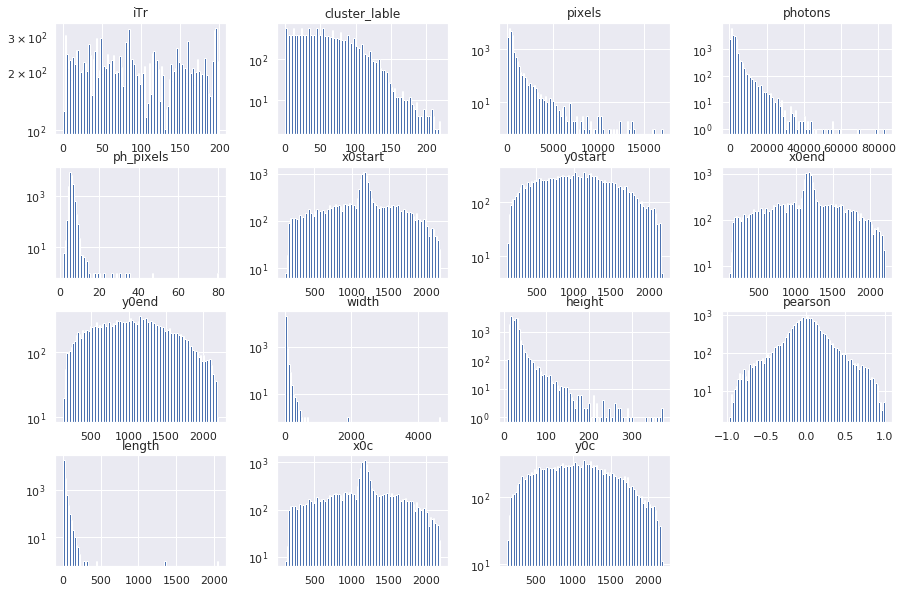

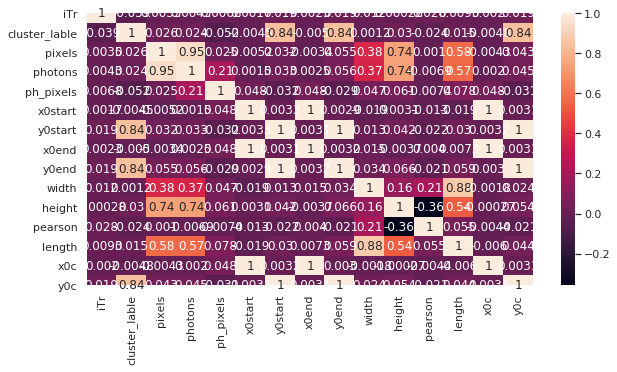

In [5]:
import seaborn as sns
sns.set()
#
# Visulizza tutte le Varibili
#
df.hist(bins=100, figsize=(15,10), log=True)
plt.show()

plt.figure(figsize = (10,5))
sns.heatmap(df.corr(), annot=True)
plt.show()

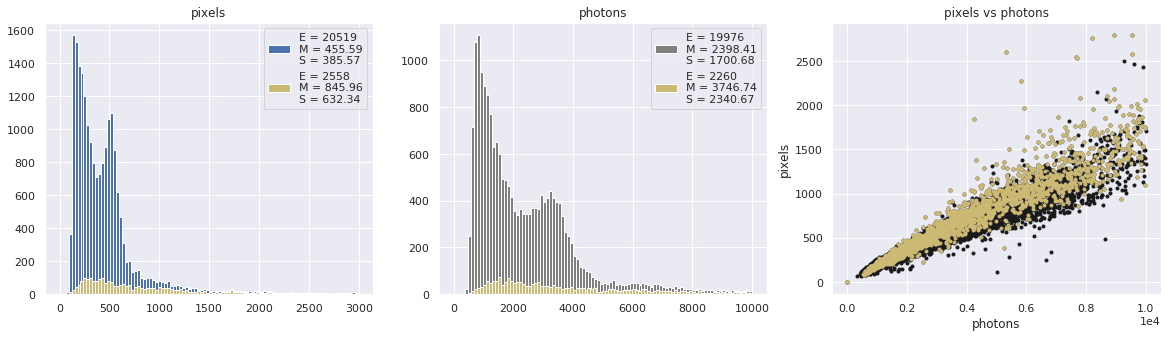

In [6]:
# cuts
phmax  = 10000
pmax   = 3000
pFeMax = 0.4
bins   = 100

fig, ax = plt.subplots(1,3, figsize=(20,5))
pd_his_plot(df.pixels[(df.pixels<pmax)], ax=ax[0], bins=bins)
pd_his_plot(df.pixels[(df.pixels<pmax) & (abs(df.pearson)>pFeMax)], ax=ax[0], bins=bins, color="y")

pd_his_plot(df.photons[df.photons<phmax], ax=ax[1], bins=bins, color="gray")
pd_his_plot(df.photons[(df.photons<phmax) & (abs(df.pearson)>pFeMax)], ax=ax[1], bins=bins, color="y")

ax[2].set_title('pixels vs photons')
ax[2].plot(df.photons[df.photons<phmax].values, df.pixels[df.photons<phmax].values, 'k.')
ax[2].plot(df.photons[(df.photons<phmax) & (abs(df.pearson)>pFeMax)].values, 
           df.pixels[(df.photons<phmax) & (abs(df.pearson)>pFeMax)].values, 'y.')

ax[2].set_xlabel('photons')
ax[2].set_ylabel('pixels')
ax[2].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
#ax[0].set_yscale('log')
#ax[1].set_yscale('log')
plt.show()

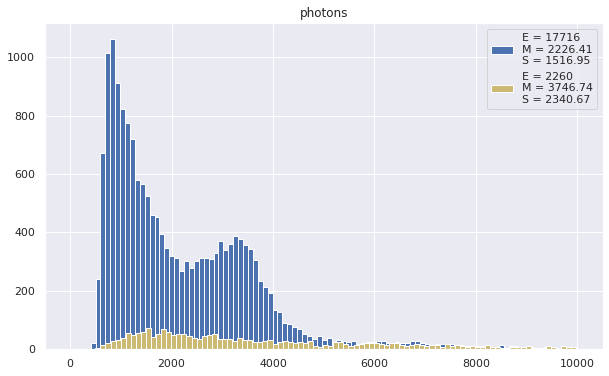

In [7]:
#
# Visualizziamo i fotoni
#
fig, ax = plt.subplots(figsize=(10,6))
pd_his_plot(df.photons[(df.photons<=phmax) & (abs(df.pearson)<pFeMax)], ax=ax, bins=bins)
pd_his_plot(df.photons[(df.photons<=phmax) & (abs(df.pearson)>pFeMax)], ax=ax, bins=bins, color="y")

#ax.hist(df.photons[abs(df.pearson)<0.4], bins, range=(0,phmax))
#ax.hist(df.photons[abs(df.pearson)>0.4], bins, range=(0,phmax), color='y')
#ax.set_yscale('log')
plt.show()

/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


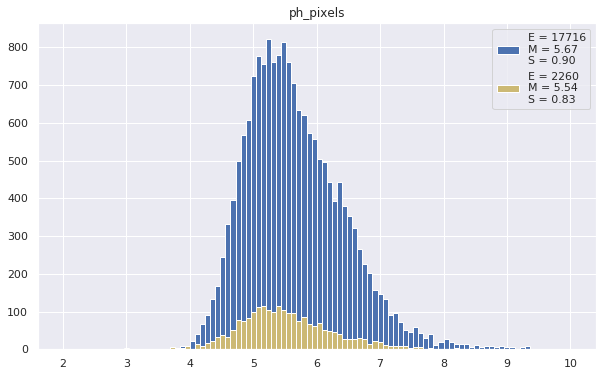

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
pd_his_plot(df.ph_pixels[(df.photons<=phmax) & (abs(df.pearson)<pFeMax)], ax=ax, bins=bins, range=(2,10))
pd_his_plot(df.ph_pixels[(df.photons<=phmax) & (abs(df.pearson)>pFeMax)], ax=ax, bins=bins, color="y", range=(2,10))

#ax.set_yscale('log')
plt.show()

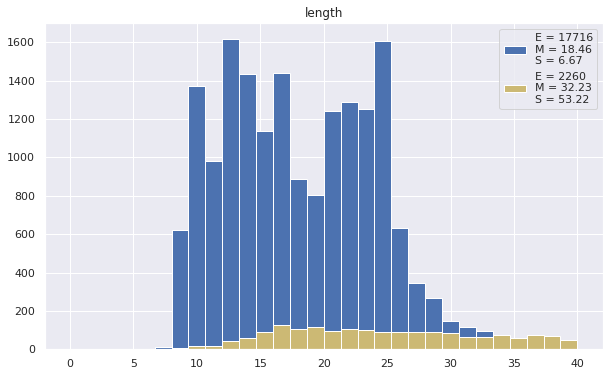

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
pd_his_plot(df.length[(df.photons<=phmax) & (abs(df.pearson)<pFeMax)], ax=ax, bins=30, range=(0,40))
pd_his_plot(df.length[(df.photons<=phmax) & (abs(df.pearson)>pFeMax)], ax=ax, bins=30, color="y", range=(0,40))

#ax.set_yscale('log')
plt.show()

Fidical Circle: 75.00 [mm]


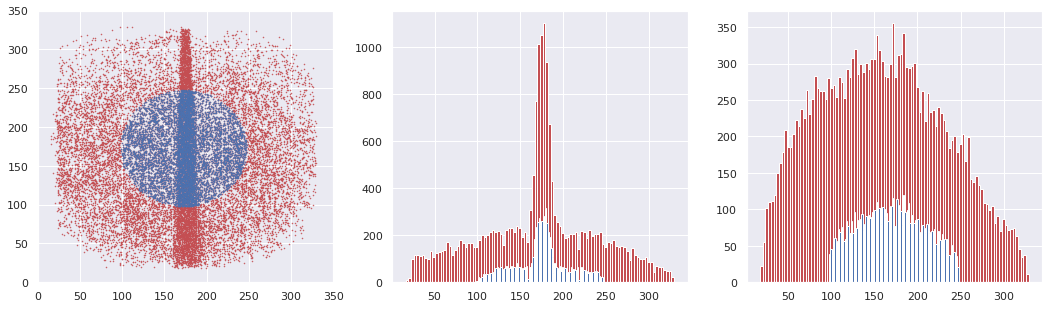

In [10]:
pd.set_option('mode.chained_assignment', None)

# Normalization

LEMON = False

if LEMON:
    # LEMON
    pixelscale  = 0.125 
    x_resolution = y_resolution = 2048
    df['length']   =df['length']*pixelscale
    df['x0c']      =df['x0c']*pixelscale
    df['y0c']      =df['y0c']*pixelscale

    # fiducializzation

    DX = 0 
    DY = 0
    a = 100. # mm 
    b = 120. # mm

    a0 = a*0.5
    b0 = b*0.5
    #################################################


    print ("Fidical Ellips: %.2f, %.2f [mm]" % (a,b))

    d0 = x_resolution*pixelscale/2

    fig, ax = plt.subplots(1,3, figsize=(18, 5))

    y = df['y0c'].values
    x = df['x0c'].values
    x1 = x[((x-d0+DX)**2/a0**2 + (y-d0+DY)**2/b0**2 )< 1]
    y1 = y[((x-d0+DX)**2/a0**2 + (y-d0+DY)**2/b0**2 )< 1]
    ax[0].plot(x, y, 'r.', markersize=1)
    ax[0].plot(x1, y1, 'b.', markersize=1)
    ax[0].set_xlim(0,256)
    ax[0].set_ylim(0,256)
    ax[1].hist(x, color='r',bins=100)
    ax[1].hist(x1, color='b',bins=100)
    ax[2].hist(y, color='r',bins=100)
    ax[2].hist(y1, color='b',bins=100)
    plt.show()

    df = df[((df['x0c']-d0)**2/a0**2 + (df['y0c']-d0)**2/b0**2 )< 1]
else:
    
    # LIME
    DX = 0 
    DY = 0

    pixelscale  = 0.150 
    x_resolution = y_resolution = 2304


    df['length']   =df['length']*pixelscale
    df['x0c']      =df['x0c']*pixelscale
    df['y0c']      =df['y0c']*pixelscale
    
    a0 = 150*.5
    print ("Fidical Circle: %.2f [mm]" % (a0))
    d0 = x_resolution*pixelscale/2

    fig, ax = plt.subplots(1,3, figsize=(18, 5))

    y = df['y0c'].values
    x = df['x0c'].values
    x1 = x[((x-d0+DX)**2/a0**2 + (y-d0+DY)**2/a0**2 )< 1]
    y1 = y[((x-d0+DX)**2/a0**2 + (y-d0+DY)**2/a0**2 )< 1]
    ax[0].plot(x, y, 'r.', markersize=1)
    ax[0].plot(x1, y1, 'b.', markersize=1)
    ax[0].set_xlim(0,350)
    ax[0].set_ylim(0,350)
    ax[1].hist(x, color='r',bins=100)
    ax[1].hist(x1, color='b',bins=100)
    ax[2].hist(y, color='r',bins=100)
    ax[2].hist(y1, color='b',bins=100)
    plt.show()

    df = df[((df['x0c']-d0)**2/a0**2 + (df['y0c']-d0)**2/a0**2 )< 1]

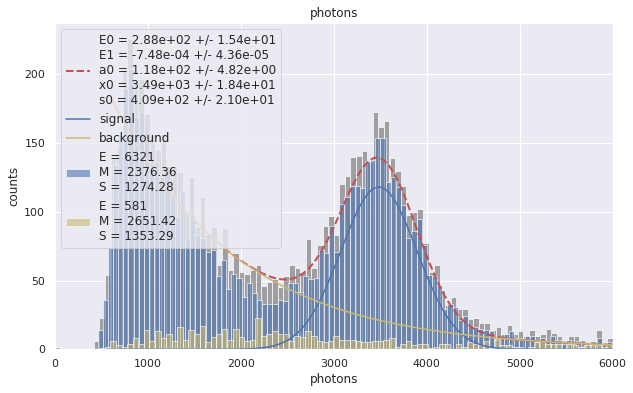

In [11]:


fig, ax = plt.subplots(figsize=(10,6))
hmax = 6000.
myExpG(df['photons'], ax, xmin=600., xmax=hmax, bins=bins, E0=200., E1=-0.001, a0=900., x0=3000., s0=300.)
ax.hist(df['photons'], bins=bins, range=(0,hmax), color='gray', alpha=0.7)
#ax.hist(df.photons[(abs(df.pearson)<0.4)], bins, range=(0,hmax), color="red", alpha=0.6, label="pearson<0.4")
#ax.hist(df.photons[(abs(df.pearson)>0.4)], bins, range=(0,hmax), color="green", alpha=0.6, label="pearson>0.4")
pd_his_plot(df.photons[(df.photons<=hmax) & (abs(df.pearson)<pFeMax)], ax=ax, bins=bins, color="b",
            alpha=0.6)
pd_his_plot(df.photons[(df.photons<=hmax) & (abs(df.pearson)>pFeMax)], ax=ax, bins=bins, color="y", 
            alpha=0.6)


ax.set_xlim(0,hmax)
ax.set_xlabel('photons')
ax.set_ylabel('counts')
#ax.set_yscale("log")
plt.legend(loc=2, prop={'size':'medium'})
plt.minorticks_on()
plt.show()

/usr/local/lib64/python3.6/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


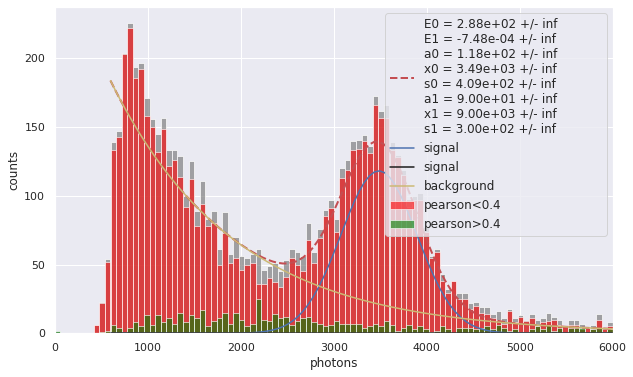

In [12]:
bins = 100

fig, ax = plt.subplots(figsize=(10,6))
#hmax = 13000.
myExp2G(df['photons'], ax, xmin=600., xmax=hmax, bins=100, E0=200., E1=-0.001, a0=900., x0=3000., s0=300., a1=90., x1=9000., s1=300.)
ax.hist(df['photons'], bins=100, range=(0,hmax), color='gray', alpha=0.7)
ax.hist(df.photons[(abs(df.pearson)<0.4)], 100, range=(0,hmax), color="red", alpha=0.6, label="pearson<0.4")
ax.hist(df.photons[(abs(df.pearson)>0.4)], 100, range=(0,hmax), color="green", alpha=0.6, label="pearson>0.4")
ax.set_xlim(0,hmax)
ax.set_xlabel('photons')
ax.set_ylabel('counts')
#ax.set_yscale("log")
plt.legend(loc=0, prop={'size':'medium'})
plt.minorticks_on()
plt.show()

/usr/local/lib64/python3.6/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


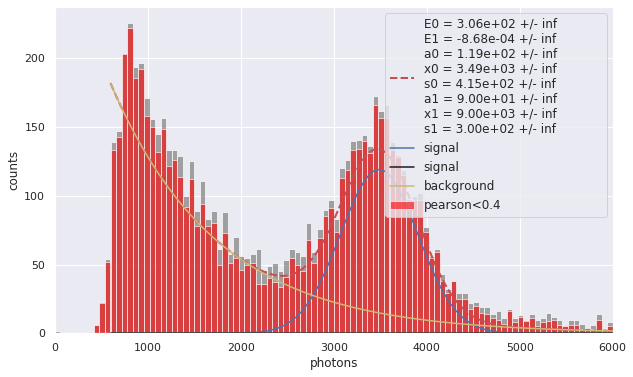

In [13]:
bins = 100

fig, ax = plt.subplots(figsize=(10,6))
#hmax = 15000.
myExp2G(df.photons[(abs(df.pearson)<0.4)], ax, xmin=600., xmax=hmax, bins=100, E0=200., E1=-0.001, a0=900., x0=3000., s0=300., a1=90., x1=9000., s1=300.)
ax.hist(df['photons'], bins=100, range=(0,hmax), color='gray', alpha=0.7)
ax.hist(df.photons[(abs(df.pearson)<0.4)], 100, range=(0,hmax), color="red", alpha=0.6, label="pearson<0.4")
#ax.hist(df.photons[(abs(df.pearson)>0.4)], 100, range=(0,hmax), color="green", alpha=0.6, label="pearson>0.4")
ax.set_xlim(0,hmax)
ax.set_xlabel('photons')
ax.set_ylabel('counts')
#ax.set_yscale("log")
plt.legend(loc=0, prop={'size':'medium'})
plt.minorticks_on()
plt.show()

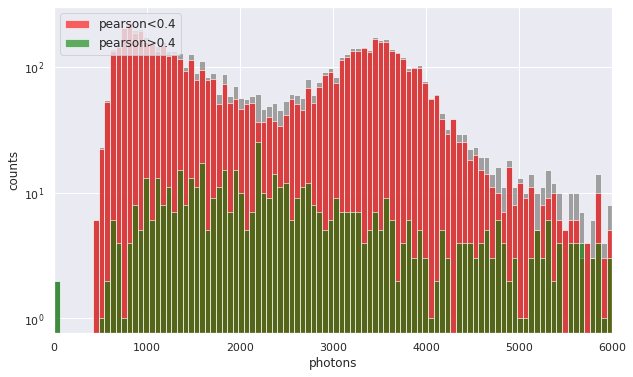

In [14]:
bins = 100

fig, ax = plt.subplots(figsize=(10,6))
#hmax = 50000.
#myExpG(dfc['photons'], ax, xmin=600., xmax=hmax, bins=100, E0=200., E1=-0.001, a0=900., x0=3000., s0=300.)
ax.hist(df['photons'], bins=100, range=(0,hmax), color='gray', alpha=0.7)
ax.hist(df.photons[(abs(df.pearson)<0.4)], 100, range=(0,hmax), color="red", alpha=0.6, label="pearson<0.4")
ax.hist(df.photons[(abs(df.pearson)>0.4)], 100, range=(0,hmax), color="green", alpha=0.6, label="pearson>0.4")
ax.set_xlim(0,hmax)
ax.set_xlabel('photons')
ax.set_ylabel('counts')
ax.set_yscale("log")
plt.legend(loc=2, prop={'size':'medium'})
plt.minorticks_on()
plt.show()

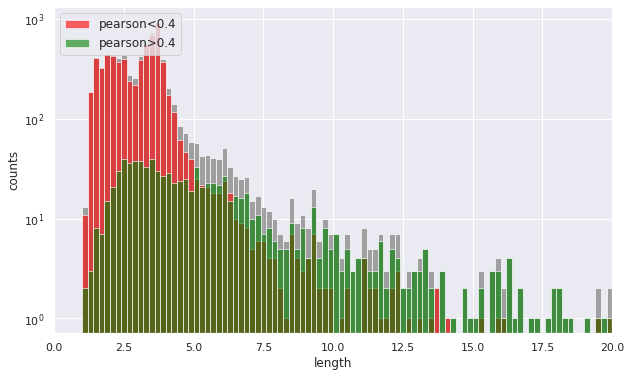

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
hmax=20
ax.hist(df.length, bins=100, range=(0,hmax), color='gray', alpha=0.7)
ax.hist(df.length[(abs(df.pearson)<0.4)], 100, range=(0,hmax), color="red", alpha=0.6, label="pearson<0.4")
ax.hist(df.length[(abs(df.pearson)>0.4)], 100, range=(0,hmax), color="green", alpha=0.6, label="pearson>0.4")
ax.set_xlim(0,hmax)
ax.set_xlabel('length')
ax.set_ylabel('counts')
ax.set_yscale("log")
plt.legend(loc=2, prop={'size':'medium'})
plt.minorticks_on()
plt.show()

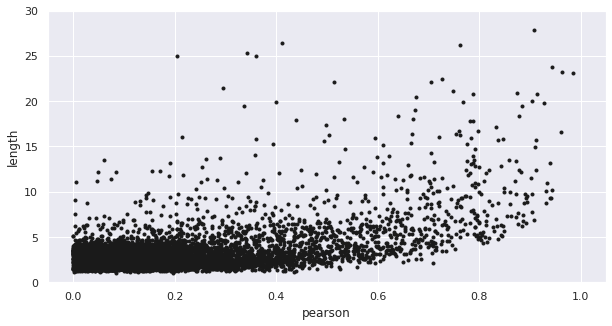

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(abs(df.pearson.values), df.length.values, 'k.')
ax.set_ylabel('length')
ax.set_xlabel('pearson')

ax.set_ylim(0,30)
plt.show()

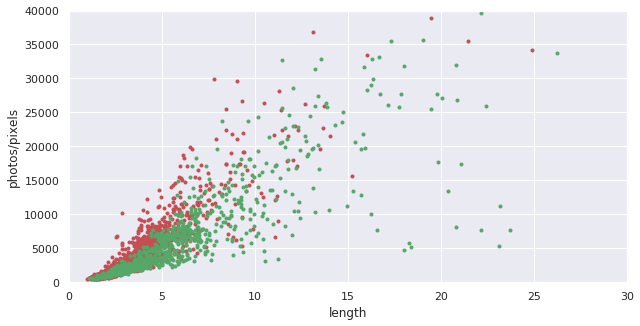

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
#ax.plot(df.length.values, df.ph_pixels.values, 'k.')
ax.plot(df.length.values[abs(df.pearson.values)<0.4], df.photons.values[abs(df.pearson.values)<0.4], 'r.')
ax.plot(df.length.values[abs(df.pearson.values)>0.4], df.photons.values[abs(df.pearson.values)>0.4], 'g.')
ax.set_ylabel('photos/pixels')
ax.set_xlabel('length')
ax.set_xlim(0,30)
ax.set_ylim(0,40000)
plt.show()

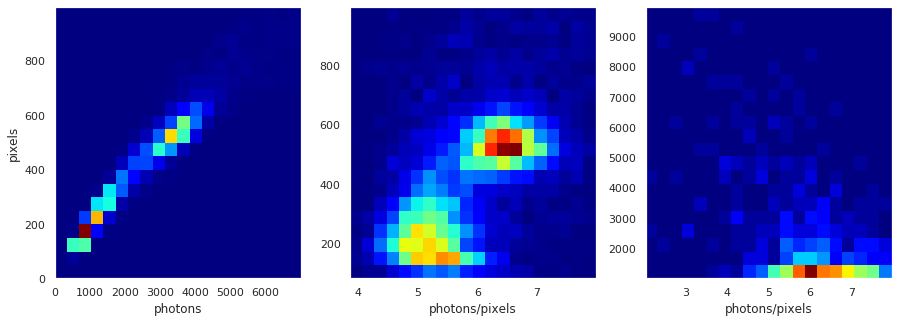

In [18]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
hmax  = 6000.
mpixe = 1000
mph   = 7000
mpphp_p = 8
ax[0].hist2d(df.photons.values[((df.pixels<mpixe)&(df.photons<mph))], 
           df.pixels.values[((df.pixels<mpixe)&(df.photons<mph))], 
           bins=(20,20), cmap=plt.cm.jet)
ax[0].set_xlabel("photons")
ax[0].set_ylabel("pixels")
ax[1].hist2d(df.ph_pixels.values[((df.pixels<mpixe)&(df.ph_pixels<mpphp_p))], 
           df.pixels.values[((df.pixels<mpixe)&(df.ph_pixels<mpphp_p))], 
           bins=(20,20), cmap=plt.cm.jet)
ax[1].set_xlabel("photons/pixels")

ax[2].hist2d(df.ph_pixels.values[(df.pixels>1000)&(df.pixels<10000)&(df.ph_pixels<mpphp_p)], 
           df.pixels.values[(df.pixels>1000)&(df.pixels<10000)&(df.ph_pixels<mpphp_p)], 
           bins=(20,20), cmap=plt.cm.jet)
ax[2].set_xlabel("photons/pixels")

plt.show()

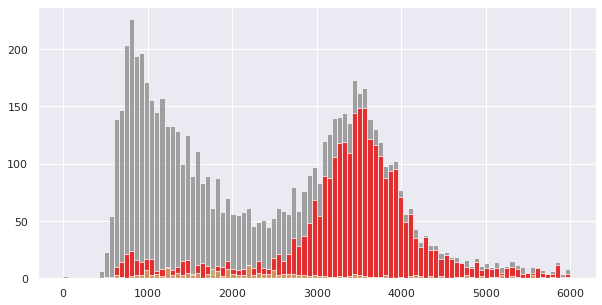

In [19]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(df['photons'], bins=bins, range=(0,hmax), color='gray', alpha=0.7)
ax.hist(df['photons'][(df.ph_pixels>6.0)], bins=bins, range=(0,hmax), color='red', alpha=0.7)
ax.hist(df['photons'][(df.ph_pixels<6.0) & ((abs(df.pearson>0.4)))], bins=bins, range=(0,hmax), color='y', alpha=0.7)

plt.show()

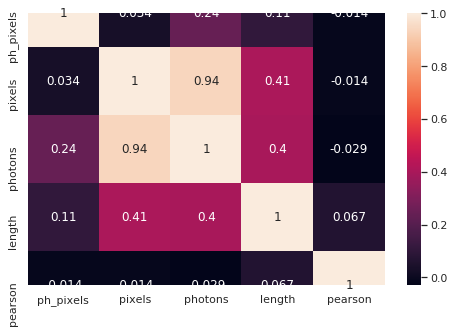

,ph_pixels,pixels,photons,length,pearson
ph_pixels,1.000000,0.033661,0.241258,0.107703,-0.014461
pixels,0.033661,1.000000,0.941320,0.406243,-0.014288
photons,0.241258,0.941320,1.000000,0.397868,-0.028848
length,0.107703,0.406243,0.397868,1.000000,0.067044
pearson,-0.014461,-0.014288,-0.028848,0.067044,1.000000


In [20]:
import seaborn as sns
# pixels	photons	ph_pixels	x0start	y0start	x0end	y0end	length	mse	r2
features = df[['ph_pixels','pixels', 'photons', 'length', 'pearson']][df['length']>0].copy()
plt.figure(figsize = (8,5))
sns.heatmap(features.corr(), annot=True)
plt.show()

features.corr()

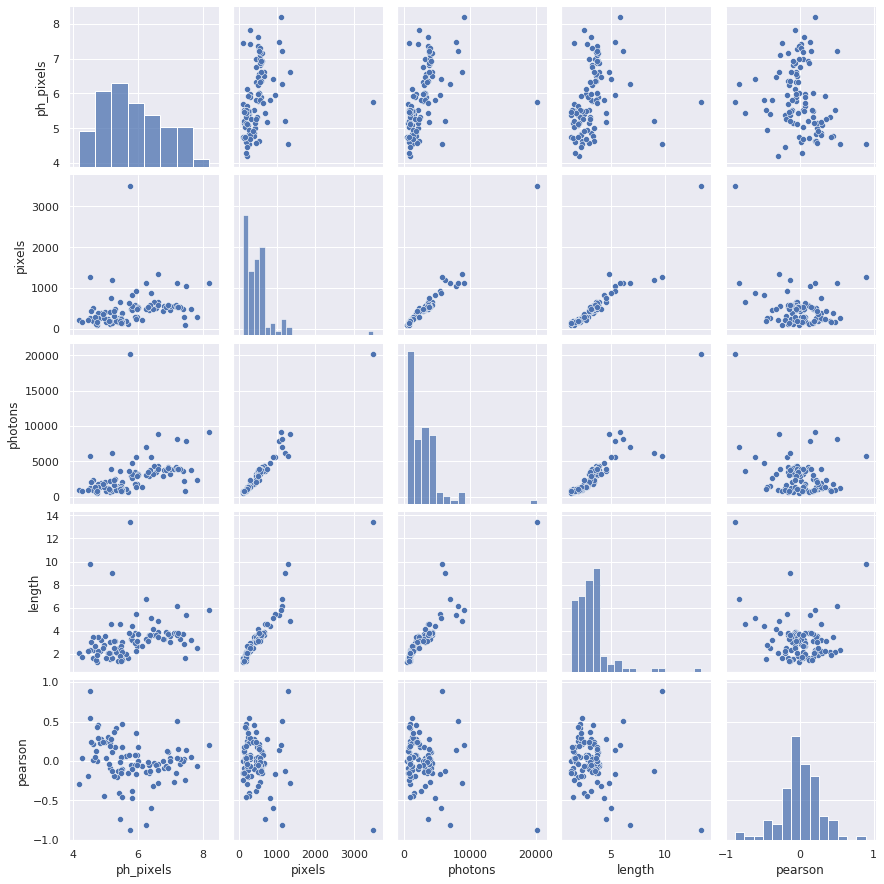

In [21]:
sns.pairplot(features.sample(100))
plt.show()

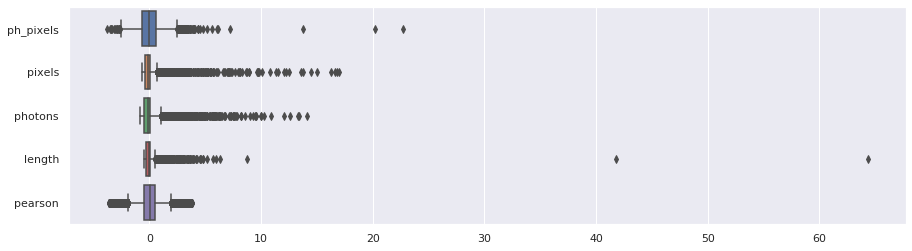

,ph_pixels,pixels,photons,length,pearson
count,7.627000e+03,7.629000e+03,7.629000e+03,7.629000e+03,7.629000e+03
mean,-1.073220e-15,7.171555e-17,6.426458e-17,-1.862741e-18,-1.560046e-17
std,1.000066e+00,1.000066e+00,1.000066e+00,1.000066e+00,1.000066e+00
min,-3.836500e+00,-7.070011e-01,-8.437893e-01,-5.259497e-01,-3.636394e+00
25%,-6.910033e-01,-4.052049e-01,-5.284982e-01,-2.676606e-01,-4.643666e-01
50%,-6.447939e-02,-1.225096e-01,-1.422809e-01,-4.395272e-02,1.061529e-02
75%,5.790885e-01,1.883797e-02,9.395360e-02,5.382643e-02,4.798080e-01
max,2.269097e+01,1.695508e+01,1.414674e+01,6.432244e+01,3.855182e+00


In [22]:
# normalizzazione delle variabili

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_array = scaler.fit_transform(features)
# pixels	photons	ph_pixels	x0start	y0start	x0end	y0end	length	mse	r2
scaled_dataframe = pd.DataFrame( scaled_array, columns = features.columns ) # df.colums per tutte e colonne
plt.figure(figsize = (15,4))
sns.boxplot(data = scaled_dataframe, orient = "h")
plt.show()
scaled_dataframe.describe()

In [23]:
scaled_dataframe

,ph_pixels,pixels,photons,length,pearson
0,-0.232318,-0.121236,-0.177813,-0.003961,-0.286128
1,-1.109904,-0.298239,-0.451513,-0.070443,-1.075291
2,-0.849351,-0.398838,-0.531836,-0.293952,-0.185905
3,-0.817121,-0.372096,-0.502585,-0.262366,0.035918
4,-1.186964,-0.401385,-0.555256,-0.259217,-0.694748
...,...,...,...,...,...
7624,-1.436985,-0.501983,-0.660585,-0.355775,0.864626
7625,0.082047,0.082508,0.103965,0.085463,-1.832143
7626,-0.683890,-0.016817,-0.122050,0.002833,0.746343
7627,0.783140,-0.090675,-0.016648,-0.046846,0.147924


In [24]:
from sklearn.cluster import KMeans

scaled_dataframe = scaled_dataframe.reset_index()
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(scaled_dataframe)
features['cluster'] = kmeans.labels_

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# analisi multifile

In [ ]:
# Bandella
file_out=["dbscan_run4184_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4183_vF0.plk.gz",
         "dbscan_run4176_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4183_vF0.plk.gz",
         "dbscan_run4168_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4183_vF0.plk.gz",
         "dbscan_run4160_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4183_vF0.plk.gz",
         "dbscan_run4152_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4183_vF0.plk.gz",
         "dbscan_run4144_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4183_vF0.plk.gz",
         "dbscan_run4136_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_197_ped_4183_vF0.plk.gz",
         "dbscan_run4128_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4183_vF0.plk.gz",
         "dbscan_run4120_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4183_vF0.plk.gz"]

d = {'run': [4184, 4176, 4160, 4168, 4152, 4144, 4136, 4128, 4120], 'd': [6.5, 11, 16, 21, 26, 31, 36, 41, 46]}


info = pd.DataFrame(data=d)

m = []
s = []
pixelscale  = 0.150 
x_resolution = y_resolution = 2304
d0 = x_resolution*pixelscale/2

# agistare il numero di file alla dimesione dei run analizzati
fig, ax = plt.subplots(3,3, figsize=(15,15))
xi = 0
yi = 0

for i, file in enumerate(file_out):
    df = pd.read_pickle(mybasepath+"out/"+file, compression='gzip')

    df['length'] = np.sqrt((df['x0end'] - df['x0start'])**2 + (df['y0end'] - df['y0start'])**2)
    df['x0c'] = (df['x0end'] + df['x0start'])/2.
    df['y0c'] = (df['y0end'] + df['y0start'])/2.
    df = df[(df['cluster_lable'] > -1) & (df['width'] > 0) & (df['height'] > 0)]
    df['length']   =df['length']*pixelscale
    df['x0c']      =df['x0c']*pixelscale
    df['y0c']      =df['y0c']*pixelscale
    # print ("Fidical Circle: %.2f, %.2f [mm]" % (a,b))
    a0 = 150*.5
    df = df[((df['x0c']-d0)**2/a0**2 + (df['y0c']-d0)**2/a0**2 )< 1]
    bins = 100

    #fig, ax = plt.subplots(figsize=(10,6))
    ax[xi,yi].set_title('run'+str(info.iloc[i,0]))
#     if i < 2:
#         hmax = 6000.
#         E0=200.
#         E1=-0.001 
#         a0=100. 
#         x0=3500.
#         s0=300.
#     elif 2 < i < 5
#     else:
#         hmax = 6000.
#         E0=200.
#         E1=-0.001
#         a0=200.
#         x0=3000.
#         s0=300.

    hmax = 6000.
    E0=200.
    E1=-0.001
    a0=200.
    x0=4000.
    s0=300.

        
    _, popt= myExpG(df['photons'], ax[xi,yi], xmin=600., xmax=hmax, bins=100, E0=E0, E1=E1, a0=a0, x0=x0, s0=s0)
    m.append(popt[3])
    s.append(popt[4])
    ax[xi,yi].hist(df['photons'], bins=100, range=(0,hmax), color='gray', alpha=0.7)
    ax[xi,yi].hist(df.photons[(abs(df.pearson)<0.4)], 100, range=(0,hmax), color="red", alpha=0.6, label="pearson<0.4")
    ax[xi,yi].hist(df.photons[(abs(df.pearson)>0.4)], 100, range=(0,hmax), color="green", alpha=0.6, label="pearson>0.4")
    ax[xi,yi].set_xlim(0,hmax)
    #ax.set_yscale("log")
    ax[xi,yi].legend(loc=2, prop={'size':'medium'})
    #plt.minorticks_on()
    yi+=1
    if yi == 3:
        xi+=1
        yi = 0
plt.show()
info['m'] = m
info['s']= s
ban = info

In [ ]:
# kfc
file_out=["dbscan_run4039_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038_vF0.plk.gz",
         "dbscan_run4040_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038_vF0.plk.gz",
         "dbscan_run4041_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038_vF0.plk.gz",
         "dbscan_run4042_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038_vF0.plk.gz",
         "dbscan_run4043_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038_vF0.plk.gz",
         "dbscan_run4044_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038_vF0.plk.gz",
         "dbscan_run4045_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038_vF0.plk.gz",
         "dbscan_run4046_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038_vF0.plk.gz",
         "dbscan_run4047_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038_vF0.plk.gz"]
d = {'run': [4039, 4040, 4041, 4042, 4043, 4044, 4045, 4046, 4047], 'd': [6.5, 11, 16, 21, 26, 31, 36, 41, 46]}

info = pd.DataFrame(data=d)

m = []
s = []
pixelscale  = 0.150 
x_resolution = y_resolution = 2304
d0 = x_resolution*pixelscale/2

# agistare il numero di file alla dimesione dei run analizzati
fig, ax = plt.subplots(3,3, figsize=(15,15))
xi = 0
yi = 0

for i, file in enumerate(file_out):
    df = pd.read_pickle(mybasepath+"out/"+file, compression='gzip')

    df['length'] = np.sqrt((df['x0end'] - df['x0start'])**2 + (df['y0end'] - df['y0start'])**2)
    df['x0c'] = (df['x0end'] + df['x0start'])/2.
    df['y0c'] = (df['y0end'] + df['y0start'])/2.
    df = df[(df['cluster_lable'] > -1) & (df['width'] > 0) & (df['height'] > 0)]
    df['length']   =df['length']*pixelscale
    df['x0c']      =df['x0c']*pixelscale
    df['y0c']      =df['y0c']*pixelscale
    # print ("Fidical Circle: %.2f, %.2f [mm]" % (a,b))
    a0 = 150*.5
    df = df[((df['x0c']-d0)**2/a0**2 + (df['y0c']-d0)**2/a0**2 )< 1]
    bins = 100

    #fig, ax = plt.subplots(figsize=(10,6))
    ax[xi,yi].set_title('run'+str(info.iloc[i,0]))
    if i < 2:
        hmax = 3000.
        E0=200.
        E1=-0.001 
        a0=100. 
        x0=2000.
        s0=300.
    else:
        hmax = 4000.
        E0=200.
        E1=-0.001
        a0=200.
        x0=3000.
        s0=300.
    hmax = 5000.
        
    _, popt= myExpG(df['photons'], ax[xi,yi], xmin=600., xmax=hmax, bins=100, E0=E0, E1=E1, a0=a0, x0=x0, s0=s0)
    m.append(popt[3])
    s.append(popt[4])
    ax[xi,yi].hist(df['photons'], bins=100, range=(0,hmax), color='gray', alpha=0.7)
    ax[xi,yi].hist(df.photons[(abs(df.pearson)<0.4)], 100, range=(0,hmax), color="red", alpha=0.6, label="pearson<0.4")
    ax[xi,yi].hist(df.photons[(abs(df.pearson)>0.4)], 100, range=(0,hmax), color="green", alpha=0.6, label="pearson>0.4")
    ax[xi,yi].set_xlim(0,hmax)
    #ax.set_yscale("log")
    ax[xi,yi].legend(loc=2, prop={'size':'medium'})
    #plt.minorticks_on()
    yi+=1
    if yi == 3:
        xi+=1
        yi = 0
plt.show()
info['m'] = m
info['s']= s
kfc = info

In [ ]:
def par_fits(info,  col='r-'):
    fig, ax = plt.subplots(1,3, figsize=(20,4))
    ax[0].set_ylabel("photons")
    ax[0].set_xlabel("ditance [cm]")
    ax[0].plot(info.d.values, info.m.values, col)
    ax[1].set_ylabel("sigma")
    ax[1].set_xlabel("ditance [cm]")
    ax[1].plot(info.d.values, info.s.values, col)
    ax[2].set_ylabel("resolution")
    ax[2].set_xlabel("ditance [cm]")
    ax[0].set_ylim(1000,5000)
    ax[1].set_ylim(200,800)
    ax[2].set_ylim(0.10,0.20)

    ax[2].plot(info.d.values, info.s.values/info.m.values, col)
    #ax[0].set_ylim(2000,4000)
    #ax[1].set_ylim(300,700)
    plt.show()

In [ ]:
par_fits(ban)

In [ ]:
par_fits(kfc, col='b-')

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,4))
ax[0].set_ylabel("photons")
ax[0].set_xlabel("ditance [cm]")
ax[0].plot(info.d.values, kfc.m.values*1.32/ban.m.values, 'g-')
ax[1].set_ylabel("sigma")
ax[1].set_xlabel("ditance [cm]")
ax[1].plot(info.d.values, kfc.s.values/ban.s.values, 'g-')
ax[2].set_ylabel("resolution")
ax[2].set_xlabel("ditance [cm]")
ax[0].set_ylim(0.5,1.2)
ax[1].set_ylim(0.5,1.2)
ax[2].set_ylim(0.5,1.2)

ax[2].plot(info.d.values, (kfc.s.values/kfc.m.values)/(ban.s.values/ban.m.values), 'g-')
#ax[0].set_ylim(2000,4000)
#ax[1].set_ylim(300,700)
plt.show()

In [ ]:
!ls

In [ ]:
! echo $file_out

In [ ]:
file_out=["dbscan_run4184_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4176_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4168_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4160_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4152_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4144_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4136_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_197_ped_4183.plk.gz",
         "dbscan_run4128_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4120_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz"]
file_out=["dbscan_run4039_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
        "dbscan_run4040_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
        "dbscan_run4041_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
        "dbscan_run4042_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
        "dbscan_run4043_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
        "dbscan_run4044_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
        "dbscan_run4045_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
        "dbscan_run4046_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
        "dbscan_run4047_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz"]


In [ ]:
# for i, file in enumerate(file_out):
#     da = mybasepath+"out/"+file
#     a = mybasepath+"bck/"+file
#     print("cp "+da+" a "+a)
#     ! cp $da $a 

In [ ]:
file_out=["dbscan_run4035_cmin_0_cmax_1000_rescale_576_nsigma_2.0_ev_100_ped_4034_vR0.plk.gz",
          "dbscan_run4035_cmin_0_cmax_1000_rescale_576_nsigma_1.5_ev_100_ped_4034_vR0.plk.gz",
          "dbscan_run4035_cmin_0_cmax_1000_rescale_576_nsigma_1.0_ev_100_ped_4034_vR0.plk.gz",
          "dbscan_run4035_cmin_0_cmax_1000_rescale_576_nsigma_0.5_ev_100_ped_4034_vR0.plk.gz",
          "dbscan_run4035_cmin_0_cmax_1000_rescale_576_nsigma_0.4_ev_100_ped_4034_vR0.plk.gz",
          "dbscan_run4035_cmin_0_cmax_1000_rescale_576_nsigma_0.3_ev_100_ped_4034_vR0.plk.gz",
          "dbscan_run4035_cmin_0_cmax_1000_rescale_576_nsigma_0.2_ev_100_ped_4034_vR0.plk.gz",
          "dbscan_run4035_cmin_0_cmax_1000_rescale_576_nsigma_0.1_ev_100_ped_4034_vR0.plk.gz"]

data = pd.DataFrame(columns=['nsigma', 'ncluster', 'ph'])

fig, ax = plt.subplots(2,4, figsize=(20,10))
xi = 0
yi = 0

for i, file in enumerate(file_out):
    fileInfo = FileNameInfo(file)
    df = pd.read_pickle(mybasepath+"out/"+file, compression='gzip')
    dataRun = run_info_logbook(int(fileInfo.dbscan[0].split('run')[-1]), verbose=False)
    rate = 0
    ph = 0
    for j in range(int(max(df.iTr))):
        rate += df[df.iTr==j].cluster_lable.max()
        ph += df[df.iTr==j].photons.sum()
    rate=rate/int(max(df.iTr))*1/float(dataRun['Exposure_Time_ms'])*1e3
    ph = ph/int(max(df.iTr))*1/float(dataRun['Exposure_Time_ms'])*1e3
        
    data = data.append({'nsigma':fileInfo.nsigma.values[0], 'ncluster':rate, 'ph':ph}, ignore_index=True)
    ax[xi,yi].set_title('nsigma = '+fileInfo.nsigma.values[0])
    ax[xi,yi].hist(df.photons, range=(0,1000),bins=100)
    yi+=1
    if yi == 4:
        xi+=1
        yi = 0
plt.show()

In [ ]:
data

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,5))
ax.plot(data.nsigma, data.ncluster, 'k.')
ax.set_ylabel('rate [Hz]')
ax.set_xlabel("# $\sigma$ over pedetal")
ax.set_title('DBSCAN min sample=2, eps=2')
plt.show()
fig, ax = plt.subplots(1, figsize=(10,5))
ax.plot(data.nsigma, data.ph, 'k.')
ax.set_ylabel('rate ph over th [Hz]')
ax.set_xlabel("# $\sigma$ over pedetal")
ax.set_title('DBSCAN min sample=2, eps=2')
plt.show()

In [ ]:
file = "dbscan_run4035_cmin_0_cmax_1000_rescale_576_nsigma_2.0_ev_100_ped_4034_vR0.plk.gz"
fileInfo = FileNameInfo(file)
df = pd.read_pickle(mybasepath+"out/"+file, compression='gzip')
dataRun = run_info_logbook(int(fileInfo.dbscan[0].split('run')[-1]), verbose=False)

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,5))
ax.hist(df.photons, range=(0,1000),bins=100)
#ax.set_yscale('log')
plt.show()